In [1]:
import torch
import torch.nn.functional as F
import nibabel as nib
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\rohit\.conda\envs\mini_project10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\rohit\.conda\envs\mini_project10\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# -------------------------------------------
# Dice coefficient computation for multilabel segmentation
def dice_coefficient(outputs, targets, threshold=0.5, smooth=1e-8):
    # Apply sigmoid to obtain probabilities and threshold to get binary predictions.
    probs = torch.sigmoid(outputs)
    preds = (probs > threshold).float()
    # Compute dice per channel: shape (B, C)
    intersection = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()

# -------------------------------------------
# Pixel accuracy computation
def pixel_accuracy(outputs, targets, threshold=0.5):
    probs = torch.sigmoid(outputs)
    preds = (probs > threshold).float()
    correct = (preds == targets).float().sum()
    total = torch.numel(preds)
    return correct / total


In [4]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import nibabel as nib

class CAMUSDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # 1) find all image files ending in .nii.gz
        image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.nii.gz')])

        # 2) build a list of (img_file, mask_file) pairs
        self.samples = []
        for img_file in image_files:
            # strip off '.nii.gz' and append '_gt.nii.gz' for the mask
            base = img_file[:-7]
            mask_file = base + '_gt.nii.gz'
            mask_path = os.path.join(mask_dir, mask_file)
            if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Mask not found for image {img_file}: expected {mask_file}")
            self.samples.append((img_file, mask_file))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_file, mask_file = self.samples[idx]
        img_path = os.path.join(self.img_dir, img_file)
        mask_path = os.path.join(self.mask_dir, mask_file)

        # load
        image = nib.load(img_path).get_fdata()
        mask  = nib.load(mask_path).get_fdata()

        # ensure channel dims
        image = np.expand_dims(image, axis=-1)
        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=-1)
        mask = mask.astype(np.int64)

        # spatial check
        if image.shape[:2] != mask.shape[:2]:
            raise ValueError(f"Spatial mismatch: {img_file} {image.shape[:2]} vs {mask_file} {mask.shape[:2]}")

        # apply transforms
        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image, mask = aug["image"], aug["mask"]
        else:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        # bring mask back to numpy for one‑hot
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        if mask.ndim == 3 and mask.shape[-1] == 1:
            mask = mask.squeeze(-1)

        # one‑hot encode into 4 channels (background + 3 classes)
        H, W = mask.shape
        one_hot = np.zeros((4, H, W), dtype=np.float32)
        for c in range(4):
            one_hot[c] = (mask == c).astype(np.float32)

        mask = torch.tensor(one_hot, dtype=torch.float32)
        return image, mask


In [5]:
# -------------------------------------------
# Define Transformations with Data Augmentation
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2()
]
)

In [6]:

# -------------------------------------------
# Load Dataset and split into Train and Validation sets
img_dir = r"E:\PROJECTS\Mini_Project\sem_6\nii_img"
mask_dir = r"E:\PROJECTS\Mini_Project\sem_6\nii_gt"
full_dataset = CAMUSDataset(img_dir=img_dir, mask_dir=mask_dir, transform=transform)
dataset_size = len(full_dataset)
print(dataset_size)
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


2000


In [ ]:

# -------------------------------------------
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=1,
    classes=4, 
    activation=None  
)
model = model.to(device)

In [8]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [9]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

#[batch_size, 1, height, width]
summary(model, input_size=[4, 1, 256 , 256])

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [4, 4, 256, 256]          --
├─ResNetEncoder: 1-1                          [4, 1, 256, 256]          --
│    └─Conv2d: 2-1                            [4, 64, 128, 128]         3,136
│    └─BatchNorm2d: 2-2                       [4, 64, 128, 128]         128
│    └─ReLU: 2-3                              [4, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                         [4, 64, 64, 64]           --
│    └─Sequential: 2-5                        [4, 256, 64, 64]          --
│    │    └─Bottleneck: 3-1                   [4, 256, 64, 64]          75,008
│    │    └─Bottleneck: 3-2                   [4, 256, 64, 64]          70,400
│    │    └─Bottleneck: 3-3                   [4, 256, 64, 64]          70,400
│    └─Sequential: 2-6                        [4, 512, 32, 32]          --
│    │    └─Bottleneck: 3-4                   [4, 512, 32, 32]          379,392

In [9]:
import torch
import torch.optim as optim
import numpy as np
from tqdm import tqdm

# Make sure that your model is defined and moved to the correct device beforehand.
# Also ensure that the model's final layer outputs 4 channels (for the one-hot mask).
# Example: model = YourModel(...).to(device)

# -------------------------------------------
# Define Loss and Optimizer with L2 Regularization
criterion = torch.nn.BCEWithLogitsLoss()  # Suitable for multi-label segmentation with one-hot targets
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# -------------------------------------------
# Training Loop with Training + Validation Metrics and tqdm
num_epochs = 50  # Increased epochs to 50

# Lists to store epoch-level metrics
train_loss_list = []
train_dice_mean_list = []
train_dice_std_list = []
train_acc_mean_list = []
train_acc_std_list = []

val_loss_list = []
val_dice_mean_list = []
val_dice_std_list = []
val_acc_mean_list = []
val_acc_std_list = []

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    dice_train_epoch = []
    acc_train_epoch = []
    train_steps = 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate dice and accuracy for this batch (make sure dice_coefficient and pixel_accuracy
        # are defined to work with one-hot masks and outputs with 4 channels)
        dice = dice_coefficient(outputs, masks)
        acc = pixel_accuracy(outputs, masks)
        dice_train_epoch.append(dice.item())
        acc_train_epoch.append(acc.item())
        
        train_steps += 1

    epoch_train_loss = running_loss / train_steps
    epoch_train_dice_mean = np.mean(dice_train_epoch)
    epoch_train_dice_std = np.std(dice_train_epoch)
    epoch_train_acc_mean = np.mean(acc_train_epoch)
    epoch_train_acc_std = np.std(acc_train_epoch)
    
    train_loss_list.append(epoch_train_loss)
    train_dice_mean_list.append(epoch_train_dice_mean)
    train_dice_std_list.append(epoch_train_dice_std)
    train_acc_mean_list.append(epoch_train_acc_mean)
    train_acc_std_list.append(epoch_train_acc_std)
    
    # --- Validation Phase ---
    model.eval()
    running_loss = 0.0
    dice_val_epoch = []
    acc_val_epoch = []
    val_steps = 0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()
            
            dice = dice_coefficient(outputs, masks)
            acc = pixel_accuracy(outputs, masks)
            dice_val_epoch.append(dice.item())
            acc_val_epoch.append(acc.item())
            
            val_steps += 1

    epoch_val_loss = running_loss / val_steps
    epoch_val_dice_mean = np.mean(dice_val_epoch)
    epoch_val_dice_std = np.std(dice_val_epoch)
    epoch_val_acc_mean = np.mean(acc_val_epoch)
    epoch_val_acc_std = np.std(acc_val_epoch)
    
    val_loss_list.append(epoch_val_loss)
    val_dice_mean_list.append(epoch_val_dice_mean)
    val_dice_std_list.append(epoch_val_dice_std)
    val_acc_mean_list.append(epoch_val_acc_mean)
    val_acc_std_list.append(epoch_val_acc_std)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train  - Loss: {epoch_train_loss:.4f}, Dice: {epoch_train_dice_mean:.4f} ± {epoch_train_dice_std:.4f}, Accuracy: {epoch_train_acc_mean:.4f} ± {epoch_train_acc_std:.4f}")
    print(f"  Val    - Loss: {epoch_val_loss:.4f}, Dice: {epoch_val_dice_mean:.4f} ± {epoch_val_dice_std:.4f}, Accuracy: {epoch_val_acc_mean:.4f} ± {epoch_val_acc_std:.4f}")

# -------------------------------------------
# Save the Final Model to a .pth file
model_save_path = "/home/sailesh/Desktop/Rohit/Combined/resnet50.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Epoch 1/50 - Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.62it/s]


Epoch 1/50:
  Train  - Loss: 0.3532, Dice: 0.7185 ± 0.1594, Accuracy: 0.8893 ± 0.1180
  Val    - Loss: 0.1779, Dice: 0.8881 ± 0.0246, Accuracy: 0.9748 ± 0.0055


Epoch 2/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.40it/s]


Epoch 2/50:
  Train  - Loss: 0.1265, Dice: 0.8857 ± 0.0263, Accuracy: 0.9753 ± 0.0052
  Val    - Loss: 0.0970, Dice: 0.8870 ± 0.0275, Accuracy: 0.9751 ± 0.0057


Epoch 3/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.40it/s]


Epoch 3/50:
  Train  - Loss: 0.0787, Dice: 0.8991 ± 0.0225, Accuracy: 0.9781 ± 0.0047
  Val    - Loss: 0.0711, Dice: 0.8976 ± 0.0279, Accuracy: 0.9778 ± 0.0050


Epoch 4/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.30it/s]


Epoch 4/50:
  Train  - Loss: 0.0642, Dice: 0.9009 ± 0.0232, Accuracy: 0.9786 ± 0.0046
  Val    - Loss: 0.0598, Dice: 0.9024 ± 0.0254, Accuracy: 0.9786 ± 0.0047


Epoch 5/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.44it/s]


Epoch 5/50:
  Train  - Loss: 0.0546, Dice: 0.9095 ± 0.0185, Accuracy: 0.9803 ± 0.0038
  Val    - Loss: 0.0534, Dice: 0.9095 ± 0.0167, Accuracy: 0.9800 ± 0.0038


Epoch 6/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.16it/s]


Epoch 6/50:
  Train  - Loss: 0.0490, Dice: 0.9147 ± 0.0179, Accuracy: 0.9815 ± 0.0036
  Val    - Loss: 0.0524, Dice: 0.9070 ± 0.0187, Accuracy: 0.9793 ± 0.0039


Epoch 7/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.77it/s]


Epoch 7/50:
  Train  - Loss: 0.0461, Dice: 0.9173 ± 0.0152, Accuracy: 0.9819 ± 0.0033
  Val    - Loss: 0.0486, Dice: 0.9133 ± 0.0164, Accuracy: 0.9805 ± 0.0037


Epoch 8/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.66it/s]


Epoch 8/50:
  Train  - Loss: 0.0477, Dice: 0.9120 ± 0.0208, Accuracy: 0.9809 ± 0.0041
  Val    - Loss: 0.0523, Dice: 0.9034 ± 0.0249, Accuracy: 0.9788 ± 0.0050


Epoch 9/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.37it/s]


Epoch 9/50:
  Train  - Loss: 0.0425, Dice: 0.9206 ± 0.0144, Accuracy: 0.9827 ± 0.0032
  Val    - Loss: 0.0448, Dice: 0.9183 ± 0.0149, Accuracy: 0.9816 ± 0.0038


Epoch 10/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.32it/s]


Epoch 10/50:
  Train  - Loss: 0.0408, Dice: 0.9231 ± 0.0147, Accuracy: 0.9832 ± 0.0032
  Val    - Loss: 0.0460, Dice: 0.9163 ± 0.0215, Accuracy: 0.9813 ± 0.0043


Epoch 11/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.52it/s]


Epoch 11/50:
  Train  - Loss: 0.0422, Dice: 0.9190 ± 0.0200, Accuracy: 0.9825 ± 0.0038
  Val    - Loss: 0.0441, Dice: 0.9194 ± 0.0180, Accuracy: 0.9818 ± 0.0043


Epoch 12/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.60it/s]


Epoch 12/50:
  Train  - Loss: 0.0403, Dice: 0.9230 ± 0.0153, Accuracy: 0.9832 ± 0.0032
  Val    - Loss: 0.0443, Dice: 0.9178 ± 0.0152, Accuracy: 0.9816 ± 0.0035


Epoch 13/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.61it/s]


Epoch 13/50:
  Train  - Loss: 0.0375, Dice: 0.9281 ± 0.0128, Accuracy: 0.9842 ± 0.0028
  Val    - Loss: 0.0457, Dice: 0.9150 ± 0.0160, Accuracy: 0.9812 ± 0.0035


Epoch 14/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.17it/s]


Epoch 14/50:
  Train  - Loss: 0.0385, Dice: 0.9259 ± 0.0182, Accuracy: 0.9838 ± 0.0035
  Val    - Loss: 0.0453, Dice: 0.9159 ± 0.0164, Accuracy: 0.9811 ± 0.0038


Epoch 15/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.34it/s]


Epoch 15/50:
  Train  - Loss: 0.0378, Dice: 0.9265 ± 0.0138, Accuracy: 0.9840 ± 0.0030
  Val    - Loss: 0.0437, Dice: 0.9195 ± 0.0216, Accuracy: 0.9819 ± 0.0047


Epoch 16/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.58it/s]


Epoch 16/50:
  Train  - Loss: 0.0356, Dice: 0.9307 ± 0.0122, Accuracy: 0.9849 ± 0.0025
  Val    - Loss: 0.0429, Dice: 0.9198 ± 0.0191, Accuracy: 0.9821 ± 0.0039


Epoch 17/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.02it/s]


Epoch 17/50:
  Train  - Loss: 0.0345, Dice: 0.9323 ± 0.0112, Accuracy: 0.9853 ± 0.0023
  Val    - Loss: 0.0419, Dice: 0.9235 ± 0.0151, Accuracy: 0.9826 ± 0.0034


Epoch 18/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.29it/s]


Epoch 18/50:
  Train  - Loss: 0.0396, Dice: 0.9233 ± 0.0238, Accuracy: 0.9834 ± 0.0048
  Val    - Loss: 0.0439, Dice: 0.9189 ± 0.0183, Accuracy: 0.9817 ± 0.0036


Epoch 19/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.49it/s]


Epoch 19/50:
  Train  - Loss: 0.0356, Dice: 0.9298 ± 0.0153, Accuracy: 0.9848 ± 0.0029
  Val    - Loss: 0.0412, Dice: 0.9226 ± 0.0134, Accuracy: 0.9826 ± 0.0035


Epoch 20/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.11it/s]


Epoch 20/50:
  Train  - Loss: 0.0334, Dice: 0.9345 ± 0.0111, Accuracy: 0.9857 ± 0.0024
  Val    - Loss: 0.0404, Dice: 0.9250 ± 0.0145, Accuracy: 0.9829 ± 0.0035


Epoch 21/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.20it/s]


Epoch 21/50:
  Train  - Loss: 0.0322, Dice: 0.9367 ± 0.0099, Accuracy: 0.9862 ± 0.0023
  Val    - Loss: 0.0415, Dice: 0.9249 ± 0.0128, Accuracy: 0.9830 ± 0.0033


Epoch 22/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.99it/s]


Epoch 22/50:
  Train  - Loss: 0.0317, Dice: 0.9376 ± 0.0094, Accuracy: 0.9864 ± 0.0021
  Val    - Loss: 0.0426, Dice: 0.9212 ± 0.0149, Accuracy: 0.9822 ± 0.0038


Epoch 23/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.47it/s]


Epoch 23/50:
  Train  - Loss: 0.0315, Dice: 0.9378 ± 0.0098, Accuracy: 0.9864 ± 0.0022
  Val    - Loss: 0.0430, Dice: 0.9205 ± 0.0152, Accuracy: 0.9822 ± 0.0035


Epoch 24/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.08it/s]


Epoch 24/50:
  Train  - Loss: 0.0329, Dice: 0.9354 ± 0.0161, Accuracy: 0.9859 ± 0.0034
  Val    - Loss: 0.0543, Dice: 0.9036 ± 0.0231, Accuracy: 0.9783 ± 0.0059


Epoch 25/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.00it/s]


Epoch 25/50:
  Train  - Loss: 0.0374, Dice: 0.9272 ± 0.0163, Accuracy: 0.9842 ± 0.0032
  Val    - Loss: 0.0423, Dice: 0.9196 ± 0.0163, Accuracy: 0.9820 ± 0.0038


Epoch 26/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.15it/s]


Epoch 26/50:
  Train  - Loss: 0.0327, Dice: 0.9354 ± 0.0111, Accuracy: 0.9860 ± 0.0024
  Val    - Loss: 0.0415, Dice: 0.9241 ± 0.0144, Accuracy: 0.9828 ± 0.0036


Epoch 27/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.86it/s]


Epoch 27/50:
  Train  - Loss: 0.0303, Dice: 0.9395 ± 0.0107, Accuracy: 0.9869 ± 0.0021
  Val    - Loss: 0.0416, Dice: 0.9257 ± 0.0139, Accuracy: 0.9831 ± 0.0034


Epoch 28/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.20it/s]


Epoch 28/50:
  Train  - Loss: 0.0294, Dice: 0.9416 ± 0.0095, Accuracy: 0.9873 ± 0.0020
  Val    - Loss: 0.0412, Dice: 0.9250 ± 0.0125, Accuracy: 0.9829 ± 0.0031


Epoch 29/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.51it/s]


Epoch 29/50:
  Train  - Loss: 0.0292, Dice: 0.9420 ± 0.0096, Accuracy: 0.9874 ± 0.0020
  Val    - Loss: 0.0411, Dice: 0.9254 ± 0.0158, Accuracy: 0.9833 ± 0.0035


Epoch 30/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.13it/s]


Epoch 30/50:
  Train  - Loss: 0.0290, Dice: 0.9428 ± 0.0091, Accuracy: 0.9875 ± 0.0022
  Val    - Loss: 0.0423, Dice: 0.9249 ± 0.0137, Accuracy: 0.9831 ± 0.0036


Epoch 31/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.16it/s]


Epoch 31/50:
  Train  - Loss: 0.0290, Dice: 0.9426 ± 0.0103, Accuracy: 0.9875 ± 0.0022
  Val    - Loss: 0.0426, Dice: 0.9230 ± 0.0157, Accuracy: 0.9826 ± 0.0037


Epoch 32/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.29it/s]


Epoch 32/50:
  Train  - Loss: 0.0289, Dice: 0.9427 ± 0.0092, Accuracy: 0.9875 ± 0.0020
  Val    - Loss: 0.0425, Dice: 0.9244 ± 0.0138, Accuracy: 0.9830 ± 0.0035


Epoch 33/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.19it/s]


Epoch 33/50:
  Train  - Loss: 0.0278, Dice: 0.9451 ± 0.0089, Accuracy: 0.9880 ± 0.0019
  Val    - Loss: 0.0496, Dice: 0.9165 ± 0.0173, Accuracy: 0.9812 ± 0.0041


Epoch 34/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.93it/s]


Epoch 34/50:
  Train  - Loss: 0.0285, Dice: 0.9433 ± 0.0090, Accuracy: 0.9876 ± 0.0019
  Val    - Loss: 0.0438, Dice: 0.9236 ± 0.0155, Accuracy: 0.9828 ± 0.0035


Epoch 35/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.97it/s]


Epoch 35/50:
  Train  - Loss: 0.0274, Dice: 0.9459 ± 0.0086, Accuracy: 0.9882 ± 0.0019
  Val    - Loss: 0.0447, Dice: 0.9242 ± 0.0154, Accuracy: 0.9829 ± 0.0039


Epoch 36/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.72it/s]


Epoch 36/50:
  Train  - Loss: 0.0273, Dice: 0.9460 ± 0.0092, Accuracy: 0.9882 ± 0.0019
  Val    - Loss: 0.0442, Dice: 0.9231 ± 0.0149, Accuracy: 0.9826 ± 0.0037


Epoch 37/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.03it/s]


Epoch 37/50:
  Train  - Loss: 0.0272, Dice: 0.9459 ± 0.0085, Accuracy: 0.9882 ± 0.0018
  Val    - Loss: 0.0425, Dice: 0.9252 ± 0.0148, Accuracy: 0.9832 ± 0.0035


Epoch 38/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.77it/s]


Epoch 38/50:
  Train  - Loss: 0.0308, Dice: 0.9394 ± 0.0157, Accuracy: 0.9869 ± 0.0032
  Val    - Loss: 0.0448, Dice: 0.9196 ± 0.0212, Accuracy: 0.9820 ± 0.0042


Epoch 39/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.64it/s]


Epoch 39/50:
  Train  - Loss: 0.0279, Dice: 0.9447 ± 0.0092, Accuracy: 0.9879 ± 0.0020
  Val    - Loss: 0.0437, Dice: 0.9232 ± 0.0159, Accuracy: 0.9828 ± 0.0035


Epoch 40/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.19it/s]


Epoch 40/50:
  Train  - Loss: 0.0259, Dice: 0.9484 ± 0.0079, Accuracy: 0.9888 ± 0.0018
  Val    - Loss: 0.0445, Dice: 0.9236 ± 0.0170, Accuracy: 0.9827 ± 0.0036


Epoch 41/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.69it/s]


Epoch 41/50:
  Train  - Loss: 0.0255, Dice: 0.9490 ± 0.0078, Accuracy: 0.9889 ± 0.0017
  Val    - Loss: 0.0441, Dice: 0.9229 ± 0.0172, Accuracy: 0.9828 ± 0.0038


Epoch 42/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.87it/s]


Epoch 42/50:
  Train  - Loss: 0.0311, Dice: 0.9388 ± 0.0152, Accuracy: 0.9867 ± 0.0032
  Val    - Loss: 0.0422, Dice: 0.9242 ± 0.0166, Accuracy: 0.9828 ± 0.0040


Epoch 43/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.83it/s]


Epoch 43/50:
  Train  - Loss: 0.0269, Dice: 0.9465 ± 0.0100, Accuracy: 0.9884 ± 0.0019
  Val    - Loss: 0.0434, Dice: 0.9252 ± 0.0146, Accuracy: 0.9832 ± 0.0036


Epoch 44/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.64it/s]


Epoch 44/50:
  Train  - Loss: 0.0256, Dice: 0.9492 ± 0.0086, Accuracy: 0.9889 ± 0.0018
  Val    - Loss: 0.0424, Dice: 0.9263 ± 0.0125, Accuracy: 0.9832 ± 0.0033


Epoch 45/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.80it/s]


Epoch 45/50:
  Train  - Loss: 0.0244, Dice: 0.9518 ± 0.0070, Accuracy: 0.9894 ± 0.0017
  Val    - Loss: 0.0433, Dice: 0.9265 ± 0.0142, Accuracy: 0.9832 ± 0.0036


Epoch 46/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.29it/s]


Epoch 46/50:
  Train  - Loss: 0.0247, Dice: 0.9510 ± 0.0084, Accuracy: 0.9893 ± 0.0017
  Val    - Loss: 0.0448, Dice: 0.9249 ± 0.0155, Accuracy: 0.9829 ± 0.0041


Epoch 47/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.72it/s]


Epoch 47/50:
  Train  - Loss: 0.0246, Dice: 0.9511 ± 0.0079, Accuracy: 0.9894 ± 0.0017
  Val    - Loss: 0.0437, Dice: 0.9253 ± 0.0166, Accuracy: 0.9832 ± 0.0035


Epoch 48/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.75it/s]


Epoch 48/50:
  Train  - Loss: 0.0246, Dice: 0.9512 ± 0.0078, Accuracy: 0.9893 ± 0.0017
  Val    - Loss: 0.0447, Dice: 0.9253 ± 0.0141, Accuracy: 0.9830 ± 0.0036


Epoch 49/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.29it/s]


Epoch 49/50:
  Train  - Loss: 0.0238, Dice: 0.9525 ± 0.0075, Accuracy: 0.9897 ± 0.0017
  Val    - Loss: 0.0442, Dice: 0.9256 ± 0.0157, Accuracy: 0.9833 ± 0.0035


Epoch 50/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 19.03it/s]


Epoch 50/50:
  Train  - Loss: 0.0243, Dice: 0.9517 ± 0.0078, Accuracy: 0.9895 ± 0.0017
  Val    - Loss: 0.0450, Dice: 0.9256 ± 0.0142, Accuracy: 0.9830 ± 0.0036
Model saved to /home/sailesh/Desktop/Rohit/Combined/resnet50.pth


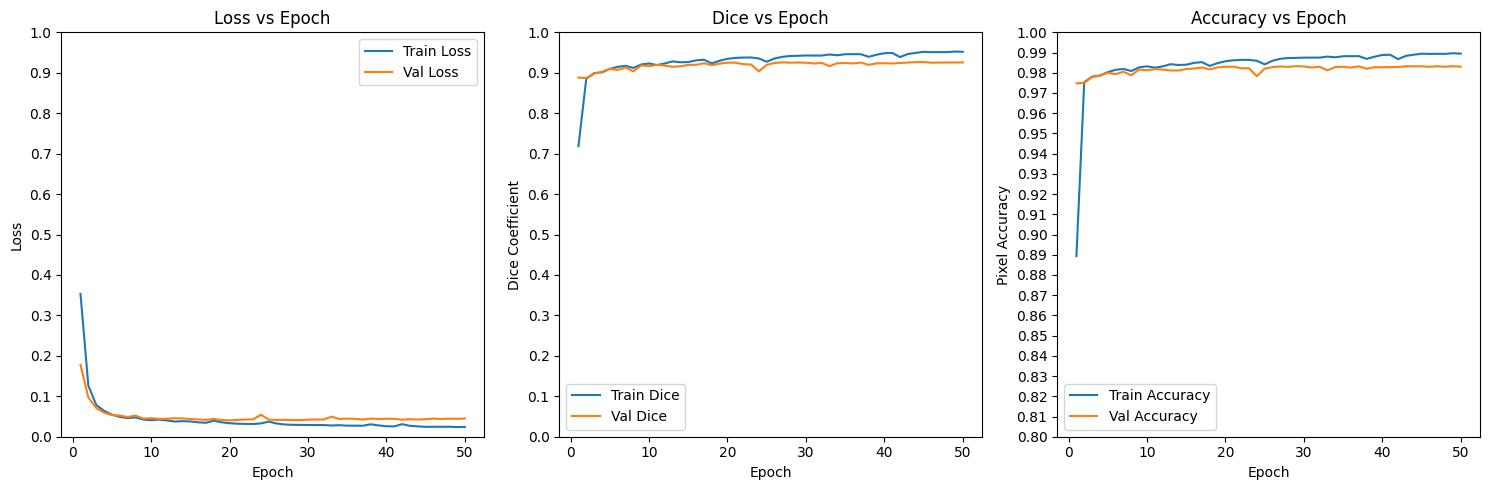

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables are defined:
# num_epochs, train_loss_list, val_loss_list,
# train_dice_mean_list, val_dice_mean_list,
# train_acc_mean_list, val_acc_mean_list

epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(15, 5))

# Loss vs Epoch
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss_list, label="Train Loss", linestyle='-')
plt.plot(epochs_range, val_loss_list, label="Val Loss", linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))

# Dice vs Epoch
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_dice_mean_list, label="Train Dice", linestyle='-')
plt.plot(epochs_range, val_dice_mean_list, label="Val Dice", linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.title("Dice vs Epoch")
plt.legend()
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))

# Accuracy vs Epoch (Y-axis adjusted from 0.8 to 1 with 0.01 scale)
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_acc_mean_list, label="Train Accuracy", linestyle='-')
plt.plot(epochs_range, val_acc_mean_list, label="Val Accuracy", linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.ylim(0.8, 1)
plt.yticks(np.arange(0.8, 1.001, 0.01))

plt.tight_layout()
plt.show()


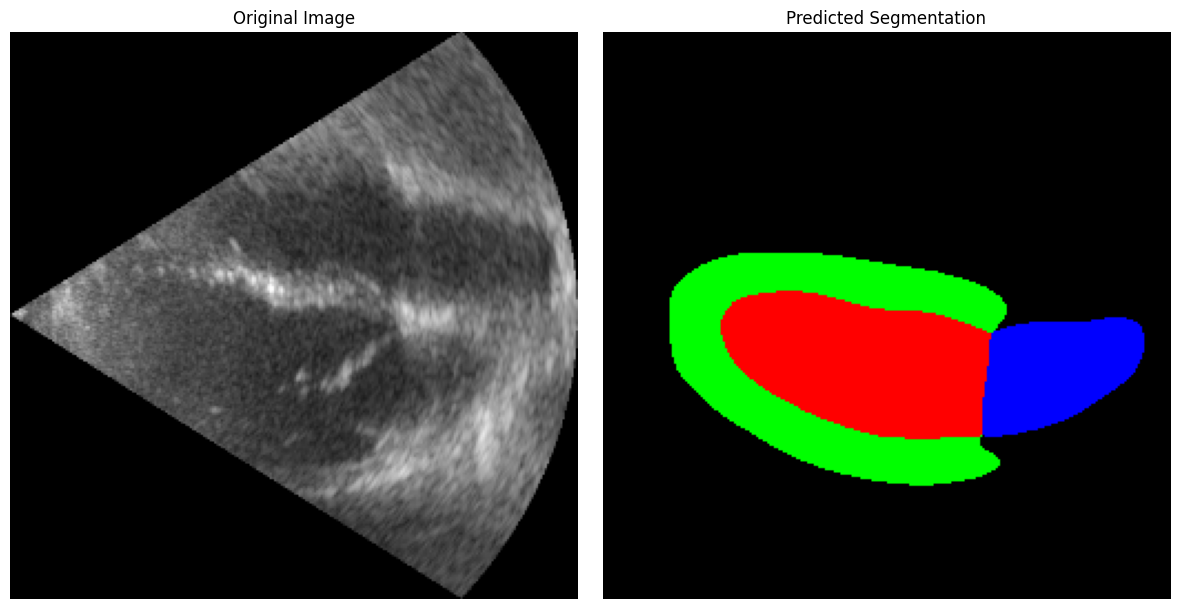

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp
import cv2  # For resizing

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Load the trained model
model_save_path = "/home/sailesh/Desktop/Rohit/Combined/Combined_efficientnet.pth"  # Update with your model path
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=1,
    classes=4,  # Background + three foreground classes
    activation=None  # No activation (BCEWithLogitsLoss)
)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)
model.eval()

# ----------------------------
# Load the input .nii.gz file
input_file = "/home/sailesh/Desktop/Rohit/codes/patient0018_4CH_ED.nii.gz"  # Update with your input file
nii_img = nib.load(input_file)
img_data = nii_img.get_fdata()

# If the image is 3D, select a middle slice
if img_data.ndim == 3:
    slice_index = img_data.shape[2] // 2
    img_slice = img_data[:, :, slice_index]
elif img_data.ndim == 2:
    img_slice = img_data
else:
    raise ValueError("Unexpected image dimensions: expected 2D or 3D image.")

# Normalize the image slice to [0, 1] for display
img_min, img_max = np.min(img_slice), np.max(img_slice)
if img_max > img_min:
    img_slice = (img_slice - img_min) / (img_max - img_min)

# ----------------------------
# Resize the image slice to 256x256
img_slice = cv2.resize(img_slice.astype(np.float32), (256, 256))

# Prepare tensor: (B=1, C=1, H, W)
img_tensor = torch.tensor(img_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

# ----------------------------
# Run inference
with torch.no_grad():
    output = model(img_tensor)  # (1, 4, 256, 256)
    output = torch.sigmoid(output)  # Convert logits to probabilities
    pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # (256, 256)

# ----------------------------
# Convert the predicted mask to a color-coded image
# We'll define a color for each class index (0..3).
# Format: BGR + alpha, but we'll only display RGB below.
colors = np.array([
    [0,   0,   0,   0],   # Class 0: background (transparent/black)
    [255, 0,   0,  255],  # Class 1: red
    [0,   255, 0,  255],  # Class 2: green
    [0,   0,  255, 255]   # Class 3: blue
], dtype=np.uint8)

H, W = pred_mask.shape
color_mask = np.zeros((H, W, 4), dtype=np.uint8)

for cls_idx in range(4):
    color_mask[pred_mask == cls_idx] = colors[cls_idx]

# Extract RGB channels (ignore alpha for display)
mask_rgb = color_mask[:, :, :3]

# ----------------------------
# Display the original slice and predicted mask separately
# ----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left: Original grayscale image
axes[0].imshow(img_slice, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Right: Predicted segmentation (color-coded)
axes[1].imshow(mask_rgb)
axes[1].set_title("Predicted Segmentation")
axes[1].axis('off')

plt.tight_layout()
plt.savefig('segmentation_side_by_side.png', bbox_inches='tight', pad_inches=0)
plt.show()


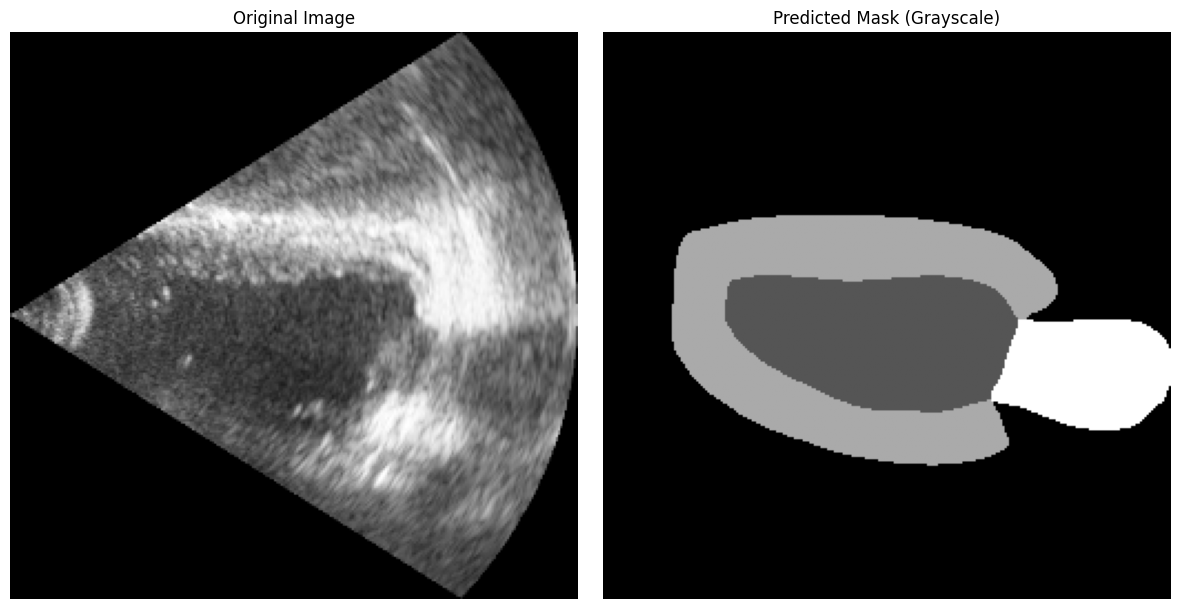

In [12]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp
import cv2  # For resizing and saving

# ----------------------------
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Load the trained model
model_save_path = "/home/sailesh/Desktop/Rohit/Combined/resnet50.pth"  # Update with your model path
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=1,
    classes=4,        # Background + three foreground classes
    activation=None   # No activation (we'll apply sigmoid + argmax ourselves)
)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)
model.eval()

# ----------------------------
# Load the input .nii.gz file
input_file = "/home/sailesh/Desktop/Rohit/Combined/patient0003_2CH_ED.nii.gz"  # Update with your input file
nii_img = nib.load(input_file)
img_data = nii_img.get_fdata()

# Select a 2D slice if 3D
if img_data.ndim == 3:
    slice_index = img_data.shape[2] // 2
    img_slice = img_data[:, :, slice_index]
elif img_data.ndim == 2:
    img_slice = img_data
else:
    raise ValueError(f"Unexpected image dimensions: {img_data.shape}")

# Normalize to [0,1]
img_min, img_max = img_slice.min(), img_slice.max()
if img_max > img_min:
    img_slice = (img_slice - img_min) / (img_max - img_min)

# Resize to 256×256
img_resized = cv2.resize(img_slice.astype(np.float32), (256, 256))

# Prepare tensor: (B=1, C=1, H=256, W=256)
img_tensor = torch.from_numpy(img_resized).unsqueeze(0).unsqueeze(0).to(device)

# ----------------------------
# Run inference
with torch.no_grad():
    logits = model(img_tensor)               # (1, 4, 256, 256)
    probs  = torch.sigmoid(logits)           # (1, 4, 256, 256)
    pred_mask = torch.argmax(probs, dim=1)   # (1, 256, 256)
    pred_mask = pred_mask.squeeze(0).cpu().numpy().astype(np.uint8)

# ----------------------------
# Optional: save the raw mask as a single‐channel PNG
# Scale classes {0,1,2,3} → {0,85,170,255} for visibility
mask_to_save = (pred_mask * (255 // 3)).astype(np.uint8)
cv2.imwrite("pred_mask_gray.png", mask_to_save)

# ----------------------------
# Display side‐by‐side: original vs. predicted mask in grayscale
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(img_resized, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Predicted mask
axes[1].imshow(pred_mask, cmap="gray", vmin=0, vmax=3)
axes[1].set_title("Predicted Mask (Grayscale)")
axes[1].axis("off")

plt.tight_layout()
plt.savefig("segmentation_side_by_side_gray.png", bbox_inches="tight", pad_inches=0)
plt.show()

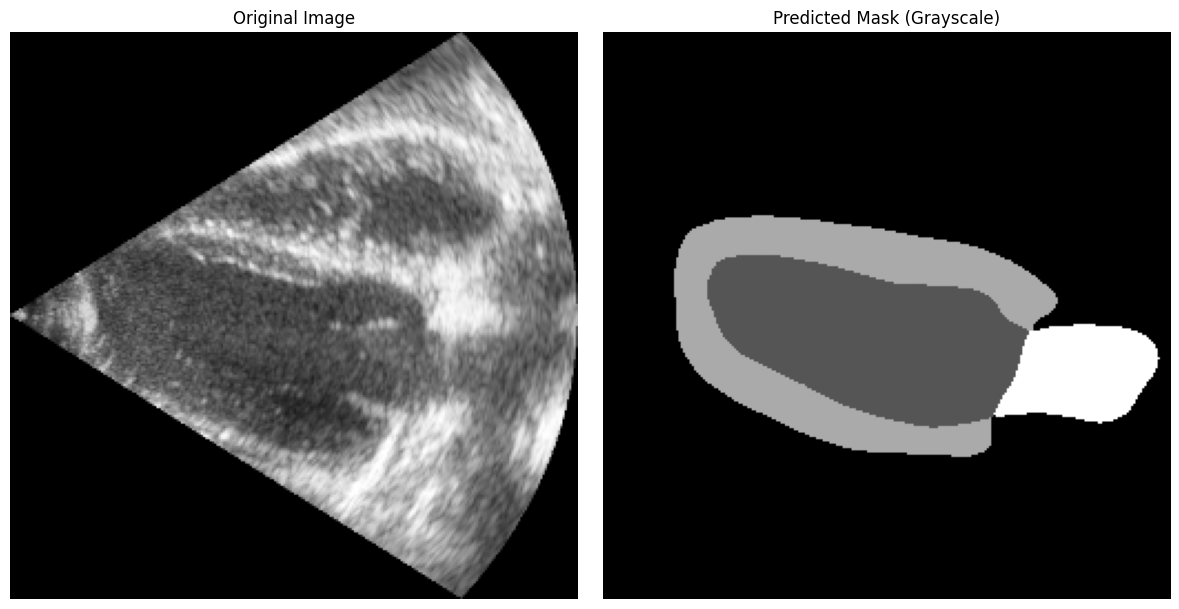

In [13]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp
import cv2  # For resizing and saving

# ----------------------------
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Load the trained model
model_save_path = "/home/sailesh/Desktop/Rohit/Combined/resnet50.pth"  # Update with your model path
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=1,
    classes=4,        # Background + three foreground classes
    activation=None   # No activation (we'll apply sigmoid + argmax ourselves)
)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)
model.eval()

# ----------------------------
# Load the input .nii.gz file
input_file = "/home/sailesh/Desktop/Rohit/Combined/patient0003_4CH_ED.nii.gz"  # Update with your input file
nii_img = nib.load(input_file)
img_data = nii_img.get_fdata()

# Select a 2D slice if 3D
if img_data.ndim == 3:
    slice_index = img_data.shape[2] // 2
    img_slice = img_data[:, :, slice_index]
elif img_data.ndim == 2:
    img_slice = img_data
else:
    raise ValueError(f"Unexpected image dimensions: {img_data.shape}")

# Normalize to [0,1]
img_min, img_max = img_slice.min(), img_slice.max()
if img_max > img_min:
    img_slice = (img_slice - img_min) / (img_max - img_min)

# Resize to 256×256
img_resized = cv2.resize(img_slice.astype(np.float32), (256, 256))

# Prepare tensor: (B=1, C=1, H=256, W=256)
img_tensor = torch.from_numpy(img_resized).unsqueeze(0).unsqueeze(0).to(device)

# ----------------------------
# Run inference
with torch.no_grad():
    logits = model(img_tensor)               # (1, 4, 256, 256)
    probs  = torch.sigmoid(logits)           # (1, 4, 256, 256)
    pred_mask = torch.argmax(probs, dim=1)   # (1, 256, 256)
    pred_mask = pred_mask.squeeze(0).cpu().numpy().astype(np.uint8)

# ----------------------------
# Optional: save the raw mask as a single‐channel PNG
# Scale classes {0,1,2,3} → {0,85,170,255} for visibility
mask_to_save = (pred_mask * (255 // 3)).astype(np.uint8)
cv2.imwrite("pred_mask_gray.png", mask_to_save)

# ----------------------------
# Display side‐by‐side: original vs. predicted mask in grayscale
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(img_resized, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Predicted mask
axes[1].imshow(pred_mask, cmap="gray", vmin=0, vmax=3)
axes[1].set_title("Predicted Mask (Grayscale)")
axes[1].axis("off")

plt.tight_layout()
plt.savefig("segmentation_side_by_side_gray.png", bbox_inches="tight", pad_inches=0)
plt.show()

In [ ]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch  # Ensure torch is imported

# -------------------------------
# Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient over all channels.
    Expects y_true and y_pred in shape (H, W, channels) or (batch, H, W, channels).
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    """
    Compute Jaccard Index (IoU) over all channels.
    Expects y_true and y_pred in shape (H, W, channels) or (batch, H, W, channels).
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred):
    
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.shape[0] == 0 or coords_pred.shape[0] == 0:
        return np.nan  # or a large number if you prefer
    d_forward = directed_hausdorff(coords_true, coords_pred)[0]
    d_backward = directed_hausdorff(coords_pred, coords_true)[0]
    distance_in_pixels = max(d_forward, d_backward)
    return distance_in_pixels

def mean_absolute_distance_multi(y_true, y_pred):
    """
    Compute the mean absolute distance (MAD) between the boundaries of masks,
    channel-by-channel, and return the average.
    """
    distances = []
    channels = y_true.shape[-1]
    for i in range(channels):
        channel_true = y_true[..., i]
        channel_pred = y_pred[..., i]
        # Convert masks to 0-255 and uint8 for contour extraction
        mask_true = (channel_true * 255).astype(np.uint8)
        mask_pred = (channel_pred * 255).astype(np.uint8)
        contours_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if len(contours_true) == 0 or len(contours_pred) == 0:
            distances.append(np.nan)
        else:
            # Combine all contour points for each mask
            points_true = np.vstack(contours_true)[:, 0, :]
            points_pred = np.vstack(contours_pred)[:, 0, :]
            dists = []
            for pt in points_true:
                dists.append(np.min(np.linalg.norm(points_pred - pt, axis=1)))
            distances.append(np.mean(dists))
    return np.nanmean(distances)

def compute_mae(y_true, y_pred):
    """
    Compute Mean Absolute Error between masks (pixel-wise).
    """
    return mean_absolute_error(y_true.flatten(), y_pred.flatten())

def compute_classification_metrics(y_true, y_pred):
    """
    Compute pixel-wise Accuracy, Precision, and Recall.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    """
    Compute Pearson correlation coefficient between ground truth and prediction.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function
# -------------------------------

def evaluate_model(model, dataloader, device, threshold=0.5):
    """
    Evaluate the model on the given dataloader and compute various metrics.
    Assumes the model outputs logits and the masks are in the range [0,1].
    """
    dice_scores = []
    jaccard_scores = []
    hausdorff_scores = []
    mae_scores = []
    mad_scores = []
    accuracies = []
    precisions = []
    recalls = []
    correlations = []

    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            # If the model returns a tuple, select the first element
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            # Apply sigmoid and threshold to get binary predictions
            preds = (torch.sigmoid(outputs) > threshold).float()

            # Move to CPU and convert to numpy
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            # The outputs are of shape (batch, channels, H, W).
            # For our metric functions, we transpose to (batch, H, W, channels).
            preds = np.transpose(preds, (0, 2, 3, 1))
            masks = np.transpose(masks, (0, 2, 3, 1))

            for pred_mask, true_mask in zip(preds, masks):
                # Binarize the ground truth mask if necessary
                true_mask_binary = (true_mask > threshold).astype(np.float32)

                dice_scores.append(dice_coefficient(true_mask_binary, pred_mask))
                jaccard_scores.append(jaccard_index(true_mask_binary, pred_mask))
                hausdorff_scores.append(hausdorff_distance_single(true_mask_binary, pred_mask))
                mae_scores.append(compute_mae(true_mask_binary, pred_mask))
                mad_scores.append(mean_absolute_distance_multi(true_mask_binary, pred_mask))

                acc, prec, rec = compute_classification_metrics(true_mask_binary, pred_mask)
                accuracies.append(acc)
                precisions.append(prec)
                recalls.append(rec)

                correlations.append(compute_correlation(true_mask_binary, pred_mask))

    print("---- Evaluation Metrics ----")
    print("Average Dice Coefficient    : {:.4f} ± {:.4f}".format(np.nanmean(dice_scores), np.nanstd(dice_scores)))
    print("Average Jaccard Index       : {:.4f} ± {:.4f}".format(np.nanmean(jaccard_scores), np.nanstd(jaccard_scores)))
    print("Average Hausdorff Distance  : {:.4f} ± {:.4f}".format(np.nanmean(hausdorff_scores), np.nanstd(hausdorff_scores)))
    print("Average Mean Absolute Error : {:.4f} ± {:.4f}".format(np.mean(mae_scores), np.std(mae_scores)))
    print("Average Mean Absolute Dist  : {:.4f} ± {:.4f}".format(np.mean(mad_scores), np.std(mad_scores)))
    print("Average Accuracy            : {:.4f} ± {:.4f}".format(np.mean(accuracies), np.std(accuracies)))
    print("Average Precision           : {:.4f} ± {:.4f}".format(np.mean(precisions), np.std(precisions)))
    print("Average Recall              : {:.4f} ± {:.4f}".format(np.mean(recalls), np.std(recalls)))
    print("Average Correlation         : {:.4f} ± {:.4f}".format(np.mean(correlations), np.std(correlations)))

# -------------------------------
# Example usage:
# -------------------------------
# Assuming `model`, `val_loader`, and `device` are defined,
# and that the model weights have been loaded correctly.

# Load your saved model weights onto CPU
model.load_state_dict(torch.load(r'/home/sailesh/Desktop/Rohit/Combined/resnet50.pth'))
model.to(device)  # device here is 'cpu'
model.eval()

# Evaluate on the validation DataLoader
evaluate_model(model, val_loader, device)


---- Evaluation Metrics ----
Average Dice Coefficient    : 0.9657 ± 0.0148
Average Jaccard Index       : 0.9341 ± 0.0267
Average Hausdorff Distance  : 3.0098 ± 0.1168
Average Mean Absolute Error : 0.0171 ± 0.0074
Average Mean Absolute Dist  : 2.1489 ± 1.4252
Average Accuracy            : 0.9829 ± 0.0074
Average Precision           : 0.9661 ± 0.0146
Average Recall              : 0.9654 ± 0.0149
Average Correlation         : 0.9543 ± 0.0197


In [ ]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff  # No longer used in soft version
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch  # Ensure torch is imported

# -------------------------------
# Single-Channel Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    """
    Compute Jaccard Index (IoU) for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred):
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.shape[0] == 0 or coords_pred.shape[0] == 0:
        return np.nan  # or a large number if you prefer

    # Compute the minimum distance from each point in coords_true to any point in coords_pred.
    min_distances_true_to_pred = [np.min(np.linalg.norm(coords_pred - a, axis=1))
                                  for a in coords_true]
    max_true_to_pred = np.max(min_distances_true_to_pred)

    # Compute the minimum distance from each point in coords_pred to any point in coords_true.
    min_distances_pred_to_true = [np.min(np.linalg.norm(coords_true - b, axis=1))
                                  for b in coords_pred]
    max_pred_to_true = np.max(min_distances_pred_to_true)

    # The Hausdorff distance is the maximum of these two distances.
    distance_in_pixels = max(max_true_to_pred, max_pred_to_true)/2
    return distance_in_pixels

def mean_absolute_distance_single(y_true, y_pred):
    """
    Compute the Mean Absolute Distance (MAD) between the boundaries of a single-channel mask.
    """
    mask_true = (y_true * 255).astype(np.uint8)
    mask_pred = (y_pred * 255).astype(np.uint8)
    contours_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours_true) == 0 or len(contours_pred) == 0:
        return np.nan
    points_true = np.vstack(contours_true)[:, 0, :]
    points_pred = np.vstack(contours_pred)[:, 0, :]

    dists = []
    for pt in points_true:
        dists.append(np.min(np.linalg.norm(points_pred - pt, axis=1)))
    return np.mean(dists)

def compute_classification_metrics(y_true, y_pred):
    """
    Compute pixel-wise Accuracy, Precision, and Recall for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    """
    Compute Pearson correlation coefficient for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function for Each Segment
# -------------------------------

def evaluate_model_by_segment(model, dataloader, device, threshold=0.5):
    """
    Evaluate the model and compute metrics for each segmentation channel (lobe) separately.
    Assumes:
      - The model outputs logits.
      - The ground truth masks are in the range [0, 1].
      - There are 4 channels: channel 0 is background and channels 1, 2, and 3 correspond to Lobe_1, Lobe_2, and Lobe_3.
    """
    num_segments = 4  # Background + 3 lobes

    # Create a list for each metric per channel
    dice_scores      = [[] for _ in range(num_segments)]
    jaccard_scores   = [[] for _ in range(num_segments)]
    hausdorff_scores = [[] for _ in range(num_segments)]
    mae_scores       = [[] for _ in range(num_segments)]
    mad_scores       = [[] for _ in range(num_segments)]
    accuracies       = [[] for _ in range(num_segments)]
    precisions       = [[] for _ in range(num_segments)]
    recalls          = [[] for _ in range(num_segments)]
    correlations     = [[] for _ in range(num_segments)]

    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            # If the model returns a tuple, select the first element
            outputs = model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            # Convert logits to binary predictions with thresholding
            preds = (torch.sigmoid(outputs) > threshold).float()

            # Move predictions and masks to CPU and convert to numpy arrays
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            # Change shape from (batch, channels, H, W) to (batch, H, W, channels)
            preds = np.transpose(preds, (0, 2, 3, 1))
            masks = np.transpose(masks, (0, 2, 3, 1))

            for pred_mask, true_mask in zip(preds, masks):
                # Iterate over segmentation channels (skip background channel 0)
                for seg in range(1, num_segments):
                    channel_pred = pred_mask[..., seg]
                    channel_true = true_mask[..., seg]

                    # Binarize the ground truth channel using the same threshold
                    channel_true_bin = (channel_true > threshold).astype(np.float32)

                    dice_scores[seg].append(dice_coefficient(channel_true_bin, channel_pred))
                    jaccard_scores[seg].append(jaccard_index(channel_true_bin, channel_pred))
                    hausdorff_scores[seg].append(hausdorff_distance_single(channel_true_bin, channel_pred))
                    mae_scores[seg].append(mean_absolute_error(channel_true_bin.flatten(), channel_pred.flatten()))
                    mad_scores[seg].append(mean_absolute_distance_single(channel_true_bin, channel_pred))

                    acc, prec, rec = compute_classification_metrics(channel_true_bin, channel_pred)
                    accuracies[seg].append(acc)
                    precisions[seg].append(prec)
                    recalls[seg].append(rec)

                    correlations[seg].append(compute_correlation(channel_true_bin, channel_pred))

    # Print averaged metrics (mean ± standard deviation) for each lobe (skipping background)
    for seg in range(1, num_segments):
        print(f"---- Metrics for Lobe_{seg} ----")
        print("Dice Coefficient    : {:.4f} ± {:.4f}".format(np.nanmean(dice_scores[seg]), np.nanstd(dice_scores[seg])))
        print("Jaccard Index       : {:.4f} ± {:.4f}".format(np.nanmean(jaccard_scores[seg]), np.nanstd(jaccard_scores[seg])))
        print("Hausdorff Distance  : {:.4f} ± {:.4f}".format(np.nanmean(hausdorff_scores[seg]), np.nanstd(hausdorff_scores[seg])))
        print("Mean Absolute Error : {:.4f} ± {:.4f}".format(np.mean(mae_scores[seg]), np.std(mae_scores[seg])))
        print("Mean Absolute Dist  : {:.4f} ± {:.4f}".format(np.mean(mad_scores[seg]), np.std(mad_scores[seg])))
        print("Accuracy            : {:.4f} ± {:.4f}".format(np.mean(accuracies[seg]), np.std(accuracies[seg])))
        print("Precision           : {:.4f} ± {:.4f}".format(np.mean(precisions[seg]), np.std(precisions[seg])))
        print("Recall              : {:.4f} ± {:.4f}".format(np.mean(recalls[seg]), np.std(recalls[seg])))
        print("Correlation         : {:.4f} ± {:.4f}".format(np.mean(correlations[seg]), np.std(correlations[seg])))
        print("-----------------------------\n")

# -------------------------------
# How to Call the Evaluation Function
# -------------------------------

# Example: After training (or loading your best model), evaluate on the validation DataLoader:
evaluate_model_by_segment(model, val_loader, device)


---- Metrics for Lobe_1 ----
Dice Coefficient    : 0.9368 ± 0.0343
Jaccard Index       : 0.8829 ± 0.0563
Hausdorff Distance  : 3.6628 ± 2.4818
Mean Absolute Error : 0.0109 ± 0.0064
Mean Absolute Dist  : 2.1724 ± 1.0362
Accuracy            : 0.9891 ± 0.0064
Precision           : 0.9517 ± 0.0548
Recall              : 0.9266 ± 0.0519
Correlation         : 0.9320 ± 0.0342
-----------------------------

---- Metrics for Lobe_2 ----
Dice Coefficient    : 0.8775 ± 0.0452
Jaccard Index       : 0.7845 ± 0.0685
Hausdorff Distance  : 4.5786 ± 2.8606
Mean Absolute Error : 0.0254 ± 0.0126
Mean Absolute Dist  : 2.3612 ± 0.8843
Accuracy            : 0.9746 ± 0.0126
Precision           : 0.8531 ± 0.0703
Recall              : 0.9089 ± 0.0560
Correlation         : 0.8653 ± 0.0485
-----------------------------

---- Metrics for Lobe_3 ----
Dice Coefficient    : 0.8971 ± 0.0945
Jaccard Index       : 0.8234 ± 0.1187
Hausdorff Distance  : 4.4083 ± 3.2326
Mean Absolute Error : 0.0094 ± 0.0071
Mean Absolute D

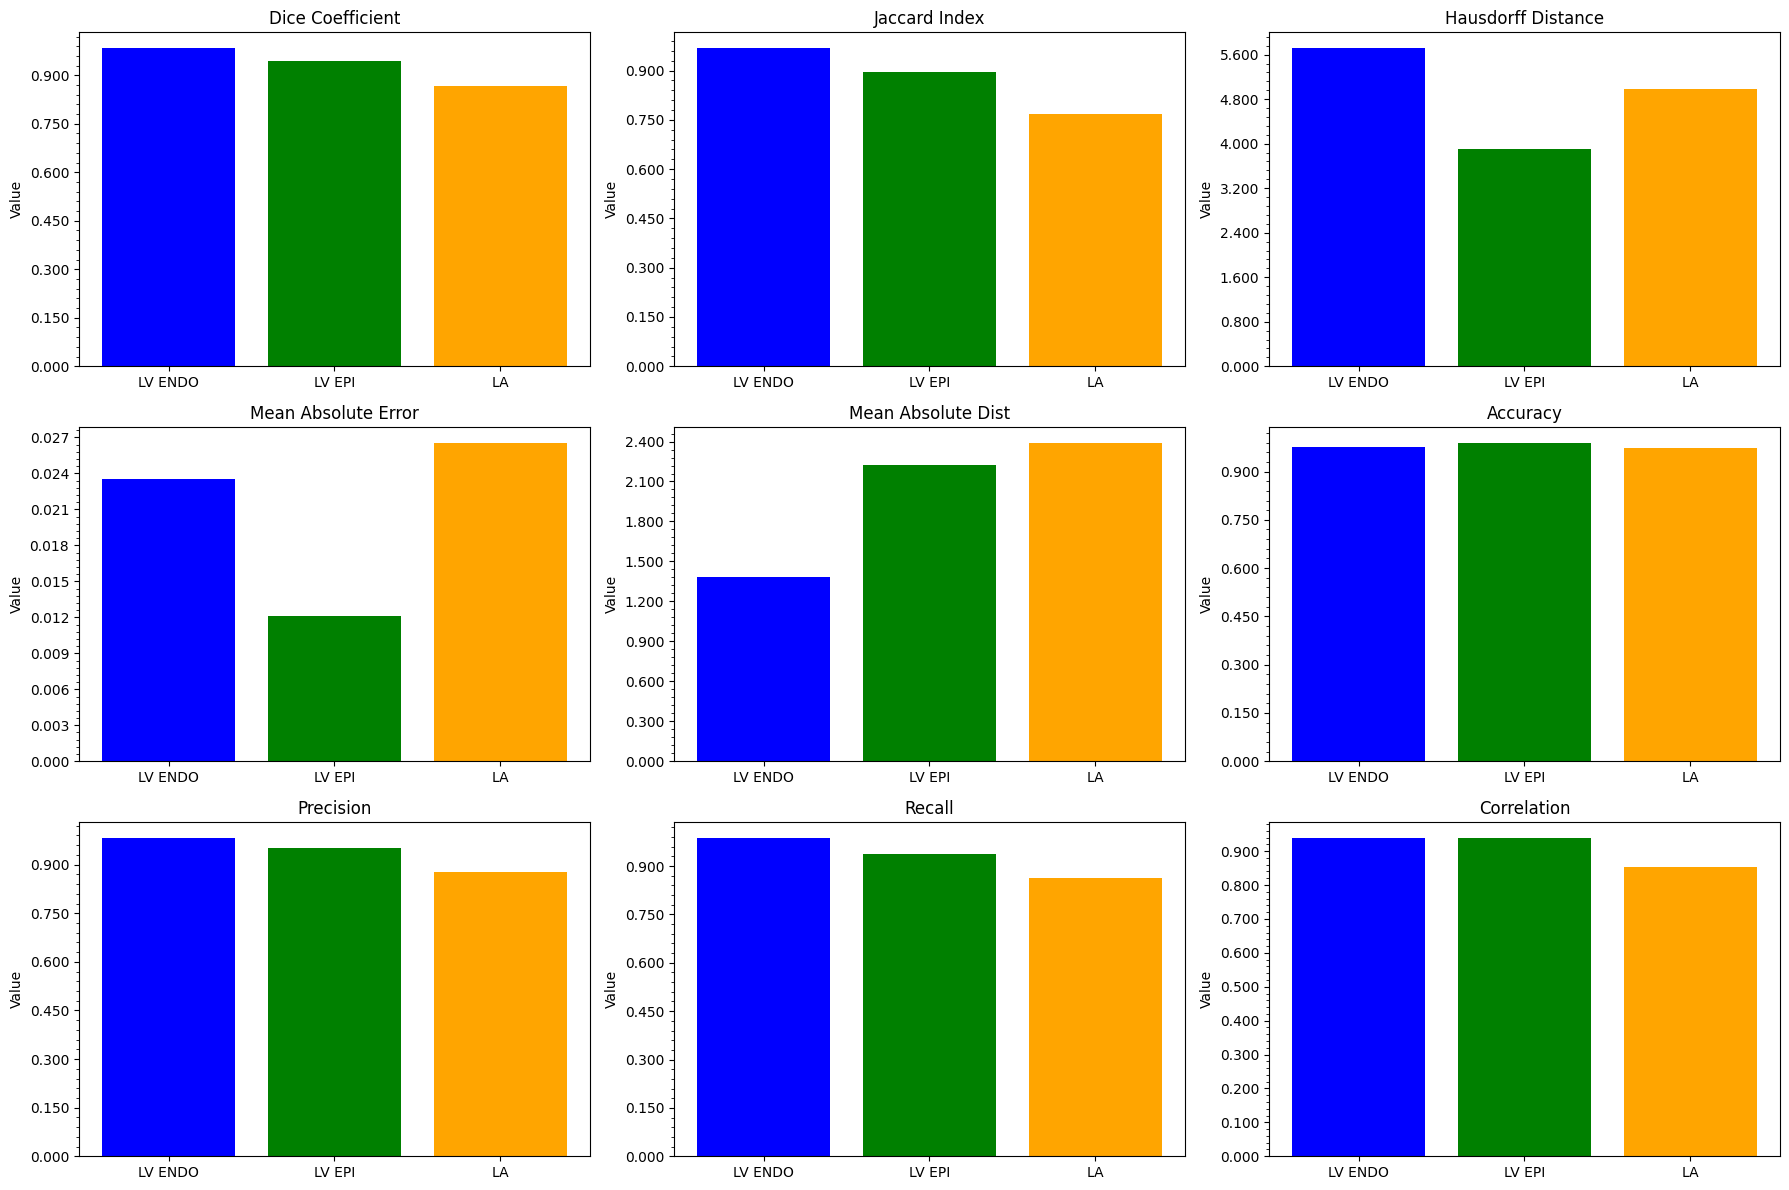

In [ ]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch  # Ensure torch is imported
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, FormatStrFormatter  # For precise y-axis scaling

# -------------------------------
# Single-Channel Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    """
    Compute Jaccard Index (IoU) for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred):
    """
    Compute the symmetric Hausdorff distance for a single-channel mask and convert the result from pixels to mm.
    """
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.shape[0] == 0 or coords_pred.shape[0] == 0:
        return np.nan  # or a large number if you prefer
    d_forward = directed_hausdorff(coords_true, coords_pred)[0]
    d_backward = directed_hausdorff(coords_pred, coords_true)[0]
    distance_in_pixels = max(d_forward, d_backward)/2
    return distance_in_pixels

def mean_absolute_distance_single(y_true, y_pred):
    """
    Compute the Mean Absolute Distance (MAD) between the boundaries of a single-channel mask.
    """
    mask_true = (y_true * 255).astype(np.uint8)
    mask_pred = (y_pred * 255).astype(np.uint8)
    contours_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours_true) == 0 or len(contours_pred) == 0:
        return np.nan
    points_true = np.vstack(contours_true)[:, 0, :]
    points_pred = np.vstack(contours_pred)[:, 0, :]

    dists = []
    for pt in points_true:
        dists.append(np.min(np.linalg.norm(points_pred - pt, axis=1)))
    return np.mean(dists)

def compute_classification_metrics(y_true, y_pred):
    """
    Compute pixel-wise Accuracy, Precision, and Recall for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    """
    Compute Pearson correlation coefficient for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function for Each Segment
# -------------------------------

def evaluate_model_by_segment(model, dataloader, device, threshold=0.5):
    """
    Evaluate the model and compute metrics for each segmentation channel separately.
    Segments are assumed to be: LV ENDO, LV EPI, and LA.
    Then, create bar plots for each metric with increased y-axis scaling for precise readings.
    """
    num_segments = 3  # For LV ENDO, LV EPI, and LA

    # Create a list for each metric per segment
    dice_scores      = [[] for _ in range(num_segments)]
    jaccard_scores   = [[] for _ in range(num_segments)]
    hausdorff_scores = [[] for _ in range(num_segments)]
    mae_scores       = [[] for _ in range(num_segments)]
    mad_scores       = [[] for _ in range(num_segments)]
    accuracies       = [[] for _ in range(num_segments)]
    precisions       = [[] for _ in range(num_segments)]
    recalls          = [[] for _ in range(num_segments)]
    correlations     = [[] for _ in range(num_segments)]

    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            # Convert logits to binary predictions with thresholding
            preds = (torch.sigmoid(outputs) > threshold).float()

            # Move predictions and masks to CPU and convert to numpy arrays
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            # Change shape from (batch, channels, H, W) to (batch, H, W, channels)
            preds = np.transpose(preds, (0, 2, 3, 1))
            masks = np.transpose(masks, (0, 2, 3, 1))

            for pred_mask, true_mask in zip(preds, masks):
                for seg in range(num_segments):
                    # Extract the segment channel (each is a 2D array)
                    channel_pred = pred_mask[..., seg]
                    channel_true = true_mask[..., seg]

                    # Compute metrics for this channel
                    dice_scores[seg].append(dice_coefficient(channel_true, channel_pred))
                    jaccard_scores[seg].append(jaccard_index(channel_true, channel_pred))
                    hausdorff_scores[seg].append(hausdorff_distance_single(channel_true, channel_pred))
                    mae_scores[seg].append(mean_absolute_error(channel_true.flatten(), channel_pred.flatten()))
                    mad_scores[seg].append(mean_absolute_distance_single(channel_true, channel_pred))

                    acc, prec, rec = compute_classification_metrics(channel_true, channel_pred)
                    accuracies[seg].append(acc)
                    precisions[seg].append(prec)
                    recalls[seg].append(rec)

                    correlations[seg].append(compute_correlation(channel_true, channel_pred))

    # Compute average metrics for each segment
    avg_dice = [np.nanmean(dice_scores[seg]) for seg in range(num_segments)]
    avg_jaccard = [np.nanmean(jaccard_scores[seg]) for seg in range(num_segments)]
    avg_hausdorff = [np.nanmean(hausdorff_scores[seg]) for seg in range(num_segments)]
    avg_mae = [np.mean(mae_scores[seg]) for seg in range(num_segments)]
    avg_mad = [np.mean(mad_scores[seg]) for seg in range(num_segments)]
    avg_accuracy = [np.mean(accuracies[seg]) for seg in range(num_segments)]
    avg_precision = [np.mean(precisions[seg]) for seg in range(num_segments)]
    avg_recall = [np.mean(recalls[seg]) for seg in range(num_segments)]
    avg_corr = [np.mean(correlations[seg]) for seg in range(num_segments)]

    # Define metric names and corresponding average values
    metrics_names = ["Dice Coefficient", "Jaccard Index", "Hausdorff Distance",
                     "Mean Absolute Error", "Mean Absolute Dist", "Accuracy",
                     "Precision", "Recall", "Correlation"]
    metrics_values = [avg_dice, avg_jaccard, avg_hausdorff, avg_mae, avg_mad,
                      avg_accuracy, avg_precision, avg_recall, avg_corr]

    # Create a 3x3 grid of bar plots (one subplot per metric)
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    axs = axs.flatten()
    segments = ['LV ENDO', 'LV EPI', 'LA']
    for i, ax in enumerate(axs):
        ax.bar(segments, metrics_values[i], color=['blue', 'green', 'orange'])
        ax.set_title(metrics_names[i])
        ax.set_ylabel("Value")
        # Increase the precision of the y-axis tick labels:
        ax.yaxis.set_major_locator(MaxNLocator(10))         # Up to 10 major ticks
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))       # 5 minor ticks between majors
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # Tick labels with 3 decimals
    plt.tight_layout()
    plt.show()

# -------------------------------
# How to Call the Evaluation Function
# -------------------------------
# Example: After training (or loading your best model), evaluate on the validation DataLoader:
evaluate_model_by_segment(model, val_loader, device)


/tmp/ipykernel_120022/1919006783.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
/tmp/ipykernel_120022/1919006783.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
/tmp/ipykernel_120022/1919006783.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
/tmp/ipykernel_120022/1919006783.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_

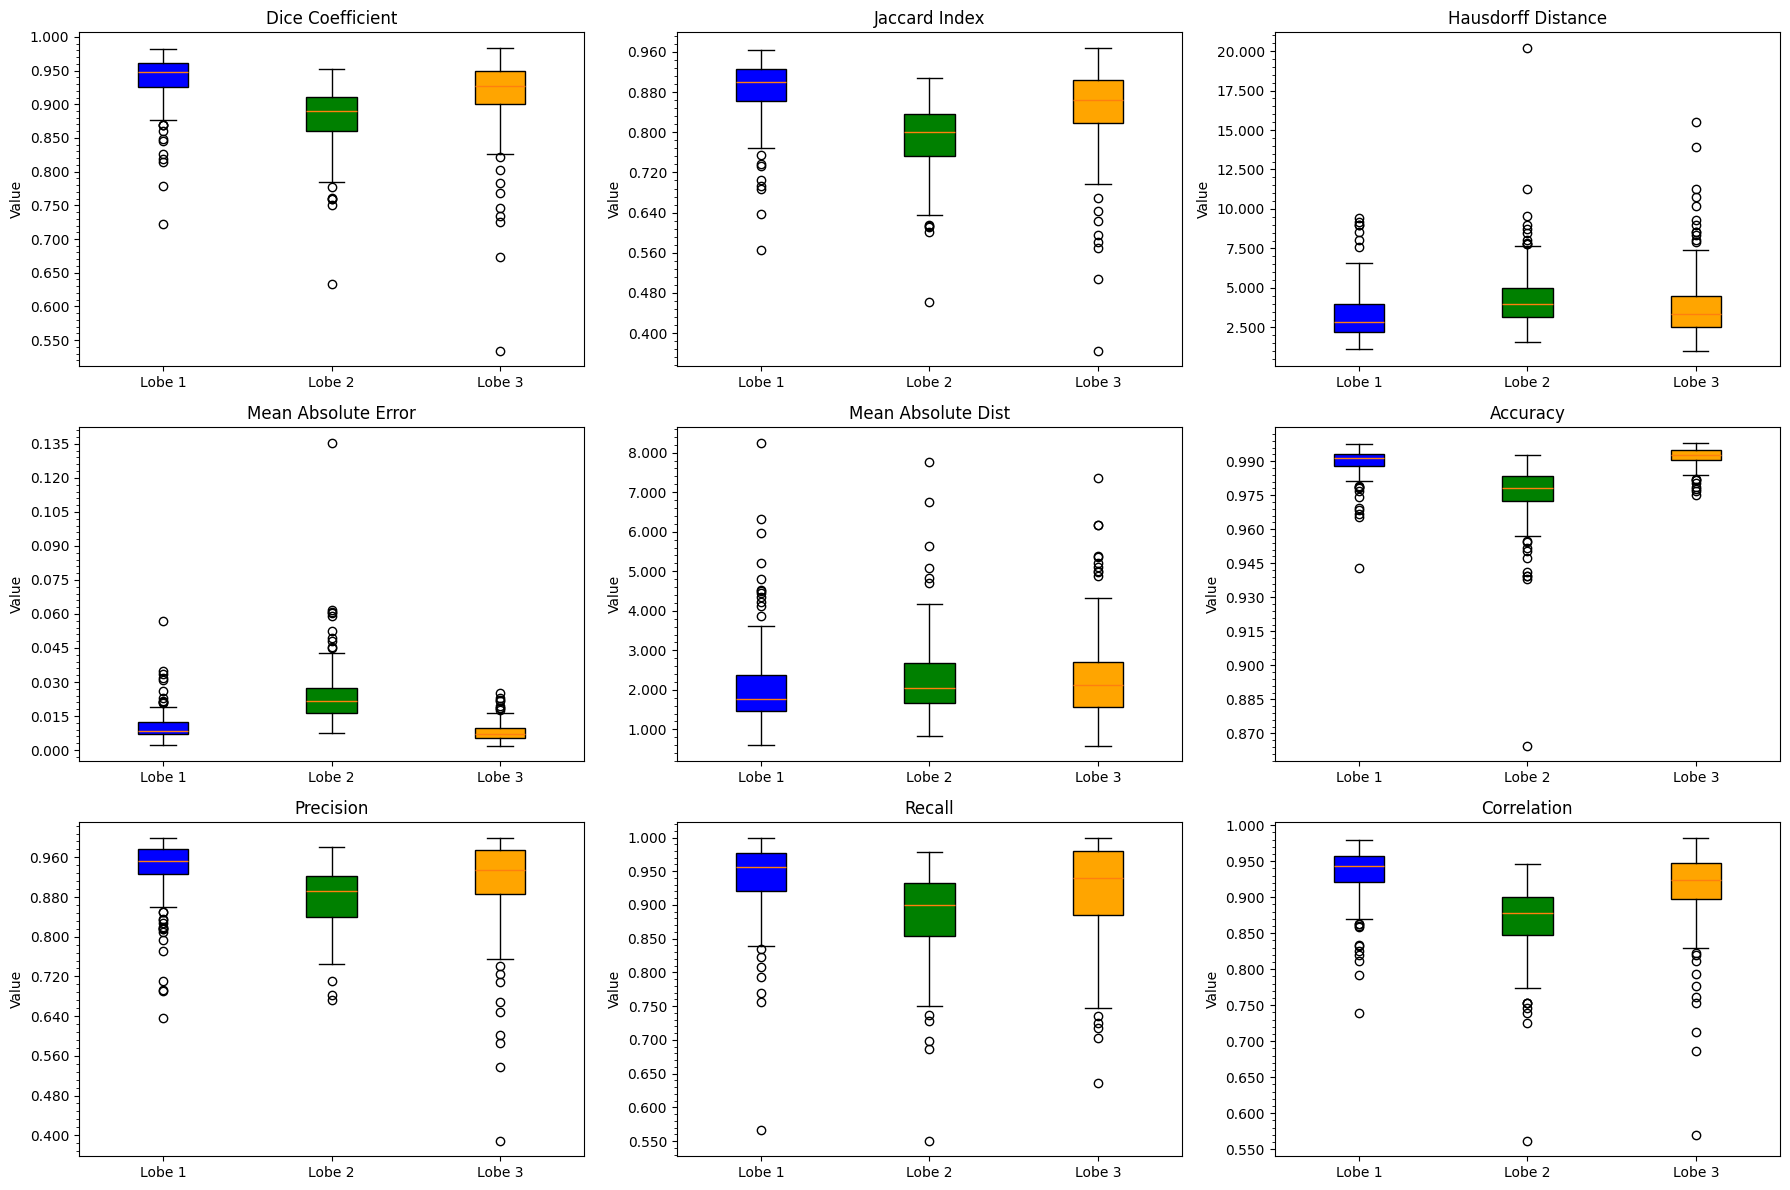

In [ ]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch  # Ensure torch is imported
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, FormatStrFormatter  # For precise y-axis scaling

# -------------------------------
# Single-Channel Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    """
    Compute Jaccard Index (IoU) for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred):
    """
    Compute the symmetric Hausdorff distance for a single-channel mask and convert the result from pixels to mm.
    """
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.shape[0] == 0 or coords_pred.shape[0] == 0:
        return np.nan  # or a large number if you prefer
    d_forward = directed_hausdorff(coords_true, coords_pred)[0]
    d_backward = directed_hausdorff(coords_pred, coords_true)[0]
    distance_in_pixels = max(d_forward, d_backward)/2
    return distance_in_pixels

def mean_absolute_distance_single(y_true, y_pred):
    """
    Compute the Mean Absolute Distance (MAD) between the boundaries of a single-channel mask.
    """
    mask_true = (y_true * 255).astype(np.uint8)
    mask_pred = (y_pred * 255).astype(np.uint8)
    contours_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours_true) == 0 or len(contours_pred) == 0:
        return np.nan
    points_true = np.vstack(contours_true)[:, 0, :]
    points_pred = np.vstack(contours_pred)[:, 0, :]

    dists = []
    for pt in points_true:
        dists.append(np.min(np.linalg.norm(points_pred - pt, axis=1)))
    return np.mean(dists)

def compute_classification_metrics(y_true, y_pred):
    """
    Compute pixel-wise Accuracy, Precision, and Recall for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    """
    Compute Pearson correlation coefficient for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function for Each Segment
# -------------------------------

def evaluate_model_by_segment(model, dataloader, device, threshold=0.5):
    """
    Evaluate the model and compute metrics for each segmentation channel (lobe) separately.
    Then, create box plots for each metric comparing Lobe_1, Lobe_2, and Lobe_3 with increased y-axis scaling for precise readings.
    """
    num_segments = 3  # For Lobe_1, Lobe_2, and Lobe_3

    # Create a list for each metric per segment
    dice_scores      = [[] for _ in range(num_segments)]
    jaccard_scores   = [[] for _ in range(num_segments)]
    hausdorff_scores = [[] for _ in range(num_segments)]
    mae_scores       = [[] for _ in range(num_segments)]
    mad_scores       = [[] for _ in range(num_segments)]
    accuracies       = [[] for _ in range(num_segments)]
    precisions       = [[] for _ in range(num_segments)]
    recalls          = [[] for _ in range(num_segments)]
    correlations     = [[] for _ in range(num_segments)]

    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            # Convert logits to binary predictions with thresholding
            preds = (torch.sigmoid(outputs) > threshold).float()

            # Move predictions and masks to CPU and convert to numpy arrays
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            # Change shape from (batch, channels, H, W) to (batch, H, W, channels)
            preds = np.transpose(preds, (0, 2, 3, 1))
            masks = np.transpose(masks, (0, 2, 3, 1))

            for pred_mask, true_mask in zip(preds, masks):
                for seg in range(num_segments):
                    # Extract the segment channel (each is a 2D array)
                    channel_pred = pred_mask[..., seg]
                    channel_true = true_mask[..., seg]

                    # Compute metrics for this channel
                    dice_scores[seg].append(dice_coefficient(channel_true, channel_pred))
                    jaccard_scores[seg].append(jaccard_index(channel_true, channel_pred))
                    hausdorff_scores[seg].append(hausdorff_distance_single(channel_true, channel_pred))
                    mae_scores[seg].append(mean_absolute_error(channel_true.flatten(), channel_pred.flatten()))
                    mad_scores[seg].append(mean_absolute_distance_single(channel_true, channel_pred))

                    acc, prec, rec = compute_classification_metrics(channel_true, channel_pred)
                    accuracies[seg].append(acc)
                    precisions[seg].append(prec)
                    recalls[seg].append(rec)

                    correlations[seg].append(compute_correlation(channel_true, channel_pred))

    # Define metric names and corresponding distributions (one per lobe)
    metrics_names = ["Dice Coefficient", "Jaccard Index", "Hausdorff Distance",
                     "Mean Absolute Error", "Mean Absolute Dist", "Accuracy",
                     "Precision", "Recall", "Correlation"]
    
    # Create a list of lists containing distributions for each metric:
    metrics_distributions = [
        dice_scores,       # Each element is a list of values for Lobe 1, 2, and 3 respectively
        jaccard_scores,
        hausdorff_scores,
        mae_scores,
        mad_scores,
        accuracies,
        precisions,
        recalls,
        correlations
    ]
    
    # Create a 3x3 grid of box plots (one subplot per metric)
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    axs = axs.flatten()
    segments = ['Lobe 1', 'Lobe 2', 'Lobe 3']
    for i, ax in enumerate(axs):
        # Create a box plot for the metric distribution across lobes
        bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
        ax.set_title(metrics_names[i])
        ax.set_ylabel("Value")
        # Optionally, customize box colors:
        colors = ['blue', 'green', 'orange']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        # Increase the precision of the y-axis tick labels:
        ax.yaxis.set_major_locator(MaxNLocator(10))         # Up to 10 major ticks
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))       # 5 minor ticks between majors
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # Tick labels with 3 decimals
    plt.tight_layout()
    plt.show()

# -------------------------------
# How to Call the Evaluation Function
# -------------------------------
# Example: After training (or loading your best model), evaluate on the validation DataLoader:
evaluate_model_by_segment(model, val_loader, device)
